# Imports

In [297]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
import math
from datetime import timedelta
from sklearn.metrics import confusion_matrix
from tensorflow.examples.tutorials.mnist import input_data

# Configuration of Neural Network

In [245]:
# convolutional layer 1
filter_size1 = 5
num_filters1 = 16

# convolutional layter 2
filter_size2 = 5
num_filters2 = 36

# full-connected layer
fc_size = 128

# Load Data

In [246]:
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz


Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [247]:
print("size of:")
print("- training-set:\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

size of:
- training-set:	55000
- Test-set:		10000
- Validation-set:	5000


In [248]:
data.test.cls = np.argmax(data.test.labels, axis=1)

## Data Dimensions

In [249]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_channels = 1
num_classes = 10

In [250]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # create figure with 3x3 sub-plots
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # plot the image
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        # show the true and predicted classes
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel)
        # remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

## Plot a few images to see if data is correct

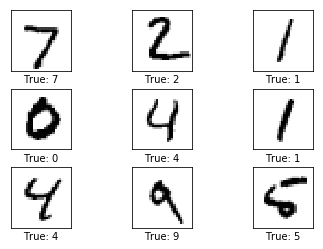

In [251]:
# get the first set images from the test-set
images = data.test.images[0:9]
# get tht true classes for those images
cls_true = data.test.cls[0:9]
# plot the images and labels using the lot_images function
plot_images(images=images, cls_true=cls_true)

# Tensorflow Graph

## helper-functions for creating new variables
create graph Variables in Tensorflow and initialize them

In [252]:
# define weight variables and initialize it
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

# define biases variables and initialize it
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

## helper-function for creating a new Convolutional Layer
The function creates a new convolutional layer in the computational graph for Tensorflow. Nothing is actually calculated here, we are just adding the mathmatical formulas to the Tensorflow graph

In [253]:
def new_conv_layer(input,   # the previous layer
                   num_input_channels, # Num. channels in prev. layer
                   filter_size, # width and height of each filter
                   num_filters, # number of filters
                   use_pooling=True): # use 2x2 max-pooling
    # shape of filter-weithts for the convolution
    # this format is determined by the Tensorflow API, that is 
    # [filter_height, filter_width, in_channels, out_channels]
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    
    # create new weights and initialize it, also known as filters with the given shape
    weights = new_weights(shape=shape)
    
    # create new biases, one for each filter
    biases = new_biases(length=num_filters)
    
    # create the TensorFlow operation for convolution
    # strides: A list of `ints`. 1-D tensor of length 4.
    # note that the strides are set to 1 in all dimensions
    # the first and last stride must always be 1
    # because the first is for the image-number and the last
    # is for input-channel. But e.g. strides=[1,2,2,1] would 
    # mean [img_num, x-axis_stride, y-axis_stride, input_channel]
    # padding='SAME': means the input image is padded with zeroes 
    # so the size of the output is the same
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    
    # add the biases to the results of convolution. A bias-value is added to each filter-channel
    layer += biases
    
    # Use pooling to down-sampling the image resolution
    # this is 2x2 max-pooling, which means that we consider 2x2 windows and select the
    # largest value in each window. Then we move 2 pixels for the next window
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    
    # Rectified Linear Unit(ReLU)
    # It calculates max(x,0) for each input pixel x.
    # since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first
    layer = tf.nn.relu(layer)
    
    # return both the resulting layer and the filter-weights
    # because we will plot the weights lagter
    return layer, weights

## helper-function for flattening a layer
A convolutional layer produces an output tensor with 4 dimensions. we will add fully-connected layers after the convolutional layers, so we need to reduce the 4-D tensor to 2-D which can be used as input to the fully-connected layer.

In [254]:
def flatten_layer(layer):
    # get the shape of input layer
    layer_shape = layer.get_shape()
    
    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]
    
    # the number of features is: img_height * img_width * img_channels
    # we can use a function from TensorFlow to calculate this
    num_features = layer_shape[1:4].num_elements()
    
    # reshape the layer to [num_images, num_features]
    # -1 means the size in that dimension is calculated
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    # return both the flattened layer and the number of features
    return layer_flat, num_features

## helper-function for creating a new Fully-connected layer
<p>This function creates a new fully-connected layer in the computational graph for TensorFlow. Nothing is actually calculated here. We are just adding the mathmatical formulars to the TensorFlow graph.
</p>
It is assumed that the input is a 2-D tensor of shape [num_images, num_inputs]. The output is a 2-D tensor of shape [num_images, num_outputs]

In [255]:
def new_fc_layer(input, # the previous layer
                 num_inputs, # num of inputs from prev. layer
                 num_outputs, # num of outputs
                 use_relu=True): # use Rectified Linear Unit (ReLU)?
    
    # create new weights and biases and initialize them 
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    
    # calculate the layer as the matrix multiplication of the input and weights, 
    # and then add the bias-values
    layer = tf.matmul(input, weights) + biases
    
    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)
        
    return layer

## placeholder variables
placeholder variables serve as the input to the TensorFlow computational graph that we may change each time we excute the graph. We call this the placeholder variables.

In [256]:
# [None, img_size_flat]: None means the tensor may hold arbitrary number of images with
# each image being a vector of length img_size_flat
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

# Since the convolutional layers expect x to be encoded as a 4-D tensor so we have to reshape it instead
# [num_images, img_height, img_width, num_channels].
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

# placeholder variable for the true labels associated with the images that were
# input in the placeholder variable x
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
# placeholder variable for true class-number
y_true_cls = tf.argmax(y_true, axis=1)

## convolutional layer 1
create the first convolutional layer. It takes x_image as input and creates num_filters1 different filters. each have width and height eqaul to filter_size1. Finally, we utilize down-sampling and 2x2 max-pooling.

In [257]:
layer_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                            num_input_channels=num_channels,
                                            filter_size=filter_size1,
                                            num_filters=num_filters1,
                                            use_pooling=True)

In [258]:
# check the shape of tensor that is (?,14,14,16) which means that
# the output is an arbitrary number of images (signed by ?)
layer_conv1

<tf.Tensor 'Relu_12:0' shape=(?, 14, 14, 16) dtype=float32>

## Convolutional layer2
create the second convolutional layer, which takes as input the output from the first convolutional layer. The numebr of input channels corresponds to the number of filters in the first convolutional layer

In [259]:
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1,
                                            num_input_channels=num_filters1,
                                            filter_size=filter_size2,
                                            num_filters=num_filters2,
                                            use_pooling=True)

In [260]:
# check the output shape of the convolutional layer2
layer_conv2

<tf.Tensor 'Relu_13:0' shape=(?, 7, 7, 36) dtype=float32>

## Flatten Layer which is prepare for the fully-connected layer
The convolutional layers output 4-D tensors. We now wish to use these as input in a fully-connected network, which requires for the tensors to be reshaped or flattened to 2-D tensors.

In [261]:
layer_flat, num_features = flatten_layer(layer_conv2)

check that the tensor now have shape (?, 1764) which means there's an arbitrary number of images which have been flattened to vectors of length 1764 each. Note that 1764 = 7x7x36

In [262]:
layer_flat

<tf.Tensor 'Reshape_22:0' shape=(?, 1764) dtype=float32>

In [263]:
num_features

## Fully-connected layer 1
add a fully-connected layer to the network. The input is the flattened layer from the previous convolution. The numeber of neurons or nodes in the fully-connected connected layer is fc_size. ReLU is used so that we can learn non-linear relation.

In [264]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features, # for one image, there will be num_features as input
                         num_outputs=fc_size,
                         use_relu=True)

In [265]:
# output the fully-connected layer shape
layer_fc1

<tf.Tensor 'Relu_14:0' shape=(?, 128) dtype=float32>

## fully-connected layer 2
add fully-connected layer that outputs vectors of length 10 for determining which of the 10 classes the input image belongs to. Note that ReLU is not used in this layer

In [266]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [267]:
layer_fc2

<tf.Tensor 'add_19:0' shape=(?, 10) dtype=float32>

## predicted classes
The second fully-connected layer estimates how likely that the input image belongs to each of the 10 classes. However, this is very diffcult to interprete because the numbers may be very small or large, so we want to normalize them so that each elements is limited between 0 and 1. And the 10 elements sum to 1. This is calculated using the so-called softmax function and the result is stored in y_pred.

In [268]:
y_pred = tf.nn.softmax(layer_fc2)

In [269]:
# the class-number is the index of the largest element
y_pred_cls = tf.argmax(y_pred, axis=1)

## cost-function to be optimized
<p>The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if predicted output of the model exactly matches the desired output then the cross-entropy equals to 0. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to 0 as possible by changing the variables of the network layers.</p>
Note that the build-in function to compute cross-entropy in the TensorFlow calculates the softmax internally so we must use the output of layer_fc2 directly rather than y_pred which has already has the softmax applied.

In [270]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)

In [271]:
cost = tf.reduce_mean(cross_entropy)

## optimization method
<p>Now we have a cost measure that must be minimized, we can create an optimizer. In this case it is the AdamOptimizer which is an advanced form of Gradient Descent</p>
Note that optimization is not performed at this point, nothing is calculated at all, we just add the optimizer-obeject to the TensorFlow graph for later excution

In [272]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

## performance measures

In [273]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [274]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# TensorFlow Run

## create TensorFlow session
Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [275]:
session = tf.Session()

## initialize variables
The variables for weights and biases must be initialized

In [276]:
session.run(tf.global_variables_initializer())

## helper-function to perform oprimization iterations

In [277]:
train_batch_size = 64

Function for performing a number of iterations so as to gradually improve the variables of the network layers. In each iteration, a new batch of data is selected from the trainining-set and then TensorFlow executes the optimizer using those training examples. The progress is printed every 100 iterations.

In [278]:
# counter for total number of iterations performed so far
total_itrations = 0

def optimize(num_iterations):
    # ensure we update the global variable rather than a local copy
    global total_itrations
    
    # count time usage
    start_time = time.time()
    
    for i in range(total_itrations, total_itrations + num_iterations):
        
        # get a batch of training examples.
        # x_batch holds a batch of images and 
        # y_true_batch are the true labels for those images
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        
        # put the batch into a dict with the proper names for placeholder
        # variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        
        # run the optimizer. TensorFlow assigns the variables to
        # the placeholder variables and then runs the optimizer
        session.run(optimizer, feed_dict=feed_dict_train)
        
        # print status every 100 iterations
        if i % 100 == 0:
            # calculate the accuracy on the training-set
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            
            # message for printing
            msg = "optimization iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            
            # print it
            print(msg.format(i + 1, acc))
    
    # update the total number of iterations performed
    total_itrations += num_iterations
    
    # ending time
    end_time = time.time()
    
    # difference between start and end time
    time_diff = end_time - start_time
    
    # print the time-usage
    print("Time usage:" + str(timedelta(seconds=int(time_diff))))

## helper-function to plot example errors
Function for plotting examples of images from the test-set that have mis-classified

In [279]:
def plot_example_errors(cls_pred, correct):
    # negate the boolean array
    incorrect = (correct == False)
    
    # get the image from the test-set for those images
    images = data.test.images[incorrect]
    
    # get the predicted classes for those images
    cls_pred = cls_pred[incorrect]
    
    # get the true classes for those images
    cls_true = data.test.cls[incorrect]
    
    # plot the first 9 images
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

## helper-function to plot confusion matrix

In [280]:
def plot_confusion_matrix(cls_pred):
    
    # get the true classifications for the test-set
    cls_true = data.test.cls
    
    # get the confusion matrix using sklearn
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    
    # print the confusion matrix as text
    print(cm)
    
    # plot the confusion matrix as an image
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # show the plot
    plt.show()

## helper-function for showing the performance
function for printing the classification accuracy on the test-set

In [281]:
# split the test-set into smaller batches of this size
test_batch_size = 256

def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):
    
    # number of images in the test-set
    num_test = len(data.test.images)
    
    # allocate an array for the predicted classes which will be calculated in batches and
    # filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    
    # calculate the predicted classes for the batches.
    # we will just iterate through all batches.
    # There might be a clever and Pythonic may of doing this
    
    # the starting index for the next batch is denoted i
    i = 0
    
    while i < num_test:
        # the ending index for the next batch is denoted j
        j = min(i + test_batch_size, num_test)
        
        # get the images from the test-set between index i and j
        images = data.test.images[i:j, :]
        labels = data.test.labels[i:j, :]
        
        # create a feed-dict with these images and labels
        feed_dict = {x: images, y_true: labels}
        
        # calculate the predicted class using TensorFlow
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        
        # set the start-index for the next batch to the end-index of the current batch
        i = j
    
    # convenience variable for the true class numbers of the test-set
    cls_true = data.test.cls
    
    # create a boolean array whether each image is correctly classified
    correct = (cls_true == cls_pred)
    
    # calculate the number of correctly classified images
    correct_sum = correct.sum()
    
    # calculate the correct accuracy
    acc = float(correct_sum) / num_test
    
    # print the accuracy
    msg = "Accuracy on Test-Set:{0:.1%}({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    
    # plot some examples of mis-classifications, if desired
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)
    
    # plot the confusion matrix, if desired
    if show_confusion_matrix:
        print("Confusion matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## performance before any optimization
The accuracy on the test-set is very low because the model variables have only been initialized and not optimized at all, so it just classifies the images randomly.

In [282]:
print_test_accuracy()

Accuracy on Test-Set:9.6%(958 / 10000)


## performance after 1 optimization iterations
The classification accuracy does not improve much from just 1 optimization iteration, because the learning-rate for the optimizer is set very low.

In [283]:
optimize(num_iterations=1)

optimization iteration:      1, Training Accuracy:  12.5%
Time usage:0:00:00


In [284]:
print_test_accuracy()

Accuracy on Test-Set:9.6%(958 / 10000)


## performance after 100 optimization iterations
After 100 optimization iterations, the model has significantly improved its classification accuracy.

In [285]:
optimize(num_iterations=99) # we already performed 1 iteration above

Time usage:0:00:07


Accuracy on Test-Set:72.6%(7261 / 10000)
Example errors:


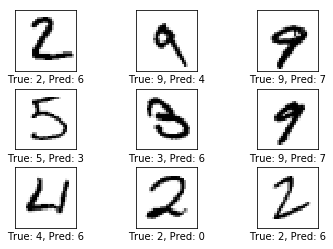

In [286]:
print_test_accuracy(show_example_errors=True)

## performance after 1000 optimization iterations

In [287]:
optimize(num_iterations=900) # we already performed 1000 iterations above

optimization iteration:    101, Training Accuracy:  78.1%


optimization iteration:    201, Training Accuracy:  79.7%


optimization iteration:    301, Training Accuracy:  85.9%


optimization iteration:    401, Training Accuracy:  89.1%


optimization iteration:    501, Training Accuracy:  92.2%


optimization iteration:    601, Training Accuracy:  98.4%


optimization iteration:    701, Training Accuracy:  92.2%


optimization iteration:    801, Training Accuracy:  89.1%


optimization iteration:    901, Training Accuracy:  89.1%


Time usage:0:01:20


Accuracy on Test-Set:92.0%(9205 / 10000)
Example errors:


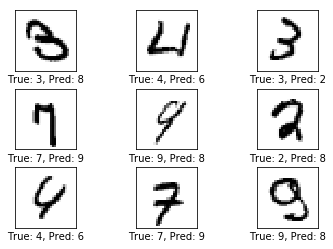

Confusion matrix:
[[ 944    0    0    0    0    2   15    1   18    0]
 [   0 1095    4    1    1    1    5    0   28    0]
 [  10    1  922    8   11    2   12   11   54    1]
 [   3    4   23  847    0   42    3   13   66    9]
 [   0    1    6    0  912    0   20    0   14   29]
 [   4    1    0    7    5  820   19    1   31    4]
 [   6    3    2    0    6   15  924    0    2    0]
 [   1    8   31    2    5    1    1  905   16   58]
 [   5    0    2    2    6    6    8    4  938    3]
 [   7    5    5    4   43    5    0    9   33  898]]


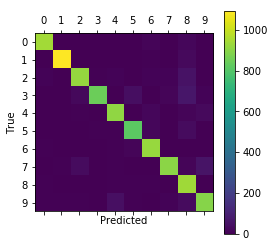

In [288]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)

# Visualization of weights and layers
In trying to understand why the convolutional neural network can recognize handwritten digits, we will now visualize the weights of the convolutional filters and the resulting output images.

## helper-function for plotting convolutional weights

In [302]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(int(num_grids), int(num_grids))

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Helper-function for plotting the output of a convolutional layer

## helper-function for plotting the output of a convolutional layer

In [310]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.
    
    # create a feed-dict containing just one image
    # note that we don't need to feed y_true because
    # it is not used in this calculation.
    feed_dict = {x: [image]}
    
    # create and retrieve the output values of the layer
    # when inputting that image
    values = session.run(layer, feed_dict=feed_dict)
    
    # number of filters used in the conv. layer
    num_filters = values.shape[3]
    
    # number of grids to plot
    # rounded-up, square root of the number of filters
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # create figure with a grid of sub-plots
    fig, axes = plt.subplots(int(num_grids), int(num_grids))
    
    # plot the output images of all the filters
    for i, ax in enumerate(axes.flat):
        # only plot the images for valid filters
        if i < num_filters:
            # get the output image of using the i'th filter.
            # see new_conv_layer() for details on the format
            # of this 4-dim tensor
            img = values[0, :, :, i]
            
            # plot the image
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # ensure the plot is shown correctly with multiple plots
    # in a single Notbook cell
    plt.show()

## input images
helper-function for plotting an image

In [291]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape), interpolation='nearest', cmap='binary')
    plt.show()

plot an image from the test-set which will be used as an example below

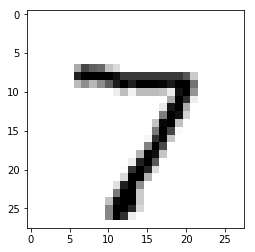

In [305]:
image1 = data.test.images[0]
plot_image(image1)

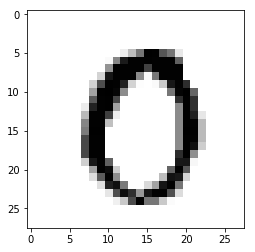

In [293]:
image2 = data.test.images[13]
plot_image(image2)

## convolution layer 1
now plot the filter-weights for the first convolutional layer
note that positive weights are red and negative weights are blue

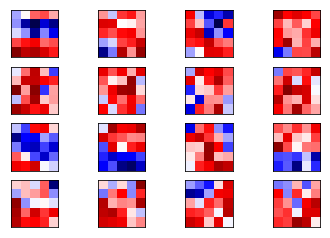

In [303]:
plot_conv_weights(weights=weights_conv1)

Appling each of these convolutional filters to the first input image gives the following output image, which are then used as input to the second convolutional layer. Note that these images are down-sampled to 14x14 pixels which is half the resolution of the origional input image.

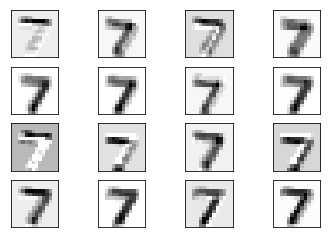

In [311]:
plot_conv_layer(layer=layer_conv1, image=image1)

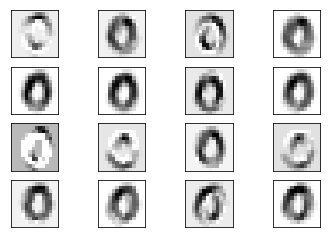

In [312]:
plot_conv_layer(layer=layer_conv1, image=image2)

## convolution layer 2
<p>now plot the filter-weights for the second convolutioal layer. There are 16 output channels from the first conv-layer, which means there are 16 input channels to the second conv-layer. The second conv-layer has a set of filer-weights for each of its input channels.</p>
we start by plotting the filter-weights for the first channel.

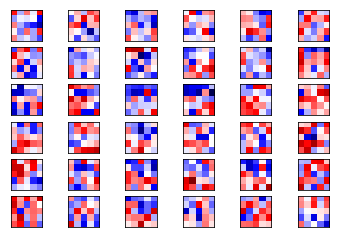

In [313]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

there are 16 input channels to the second convolutional layer, so we can make another 15 plots of filter-weights like this. we just make one moere with filter-weights for the second channel.

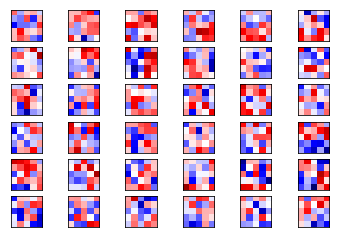

In [316]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

It's diffcult to understand and keep track of how these applied because of high dimensionality. Applying these convolutional filters to the images that were output from the first conv-layer gives the following images. Note: these are down-sampled yet again 7x7 pixels which is half the resolution of the images from the first conv-layer

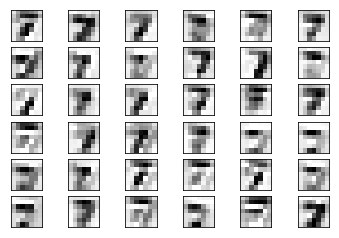

In [317]:
plot_conv_layer(layer=layer_conv2, image=image1)

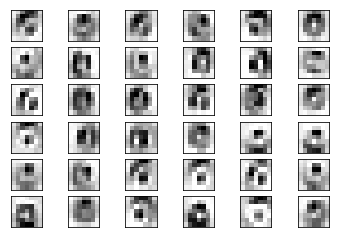

In [318]:
plot_conv_layer(layer=layer_conv2, image=image2)

## close TensorFlow Session
we are not done using TensorFlow, so we close the session to release its resources

In [ ]:
# session.close()